# Example 3.3: Auto-spectral density

In this example, we will compute the auto spectral density from an auto correlation function in three different ways.

## Auto correlation function

We will consider the following function:

$$ R(\tau)= \sigma^2 \exp(-\dfrac{\tau^2}{2L^2}) \cos(\bar{\omega} t)$$

where $\sigma=10$, $L=2$, and $\bar{\omega}=6$. Let's start by plotting this function.


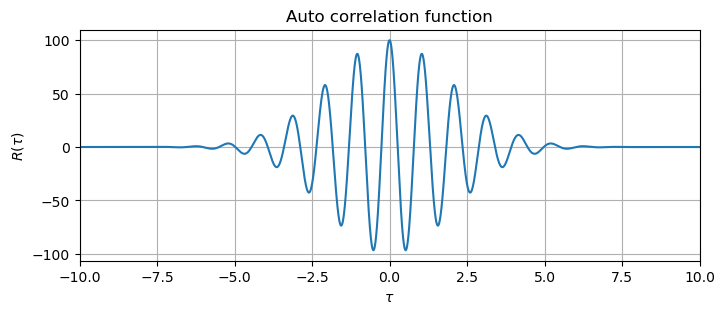

In [8]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters
sigma=10.0
L=2.0
omega_bar=6.0

# Generate time axis
dtau=0.001
tau_max = 10.0  # Maximum time lag
tau=np.arange(-tau_max,tau_max+dtau,dtau) # tau axis

# Define the auto correlation 
R = sigma**2*np.exp(-tau**2 / (2 * L**2))*np.cos(omega_bar*tau)

# Plot
plt.figure(figsize=(8, 3))
plt.plot(tau, R)
plt.xlim(-10,10)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R(\tau)$')
plt.title('Auto correlation function')
plt.grid(True)


The figure shows that the process has a cyclic, fading correlation. This indicates that this stochastic process is dominated by a frequency, which unsurprisingly is related to the parameter $\bar{\omega}$. This will be better illustrated from the spectral density.

## Method 1: Analytical Fourier transform

The spectral density is defined as:

$$
S(\omega)=
\dfrac{1}{2 \pi}
\int_{-\infty}^{\infty}
R(\tau) \exp({-i \omega \tau}) \: \text{d} \tau
$$


We have to solve the integral. Not all functions can be transformed to the frequency domain analytically, but functions containing $\exp()$ and $\cos()$ are usually easy to integrate. This function has probably been considered by many before us. Asking a language model can likely help us.

<p align="center">
    <img src="figures\FT_chatgpt1.png" alt="Plot 1" style="width: 580px; display: inline-block; border: 1px solid black">
    <img src="figures\FT_chatgpt2.png" alt="Plot 2" style="width: 480px; display: inline-block; border: 1px solid black">
</p>

The solution looks correct, but it has "forgotten" the $\dfrac{1}{2\pi}$ factor in front of the FT integral in Step 2. This is because the FT can be defined (scaled) in several ways. However, we always use the scaling $\dfrac{1}{2\pi}$. Therefore, the spectral density is:

$$
S(\omega)=
\sigma^2
\dfrac{1}{2\pi}
\sqrt{\frac{\pi L^2}{2}} \left[ \exp \Big({-\frac{L^2(\bar{\omega} - \omega)^2}{2}} \Big) + \exp \Big( {-\frac{L^2(\bar{\omega} + \omega)^2}{2}} \Big) \right]
$$



100.0


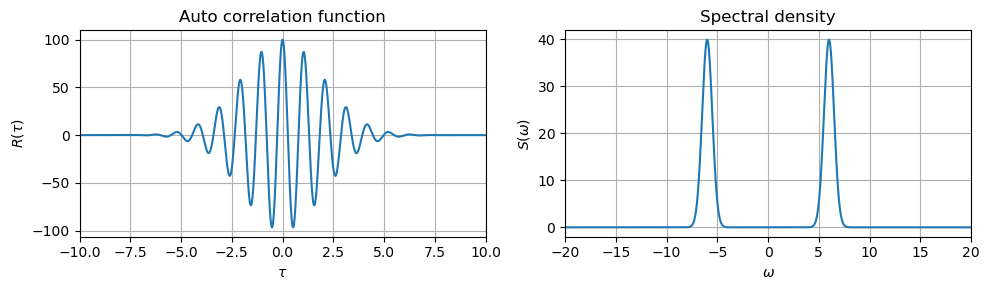

In [9]:
# Frequency axis
domega=0.02
omega=np.arange(-20,20+domega,domega)

# Analytical solution
S=sigma**2/(2*np.pi)*np.sqrt(np.pi*L**2/2)*( np.exp(-L**2*(omega_bar-omega)**2/2) + np.exp(-L**2*(omega_bar+omega)**2/2) )

# Plot
plt.figure(figsize=(10, 3))

# Plot auto correlation
plt.subplot(1, 2, 1)
plt.plot(tau,R)
plt.xlim(-10,10)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R(\tau)$')
plt.title('Auto correlation function')
plt.grid(True)

# Plot PSD
plt.subplot(1, 2, 2)
plt.plot(omega,S, label='PSD')
plt.xlim(-20,20)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.title('Spectral density')
plt.grid(True)

plt.tight_layout()

print(np.trapz(S,omega))

## Method 2: Fourier transform by numerical integration

The spectral density is defined as:
$$
S(\omega)=
\dfrac{1}{2 \pi}
\int_{-\infty}^{\infty}
R(\tau) \exp({-i \omega \tau}) \: \text{d} \tau
$$

We can use the trapezoidal rule to calculate the integral. The integral must then be calculated for each $\omega$.

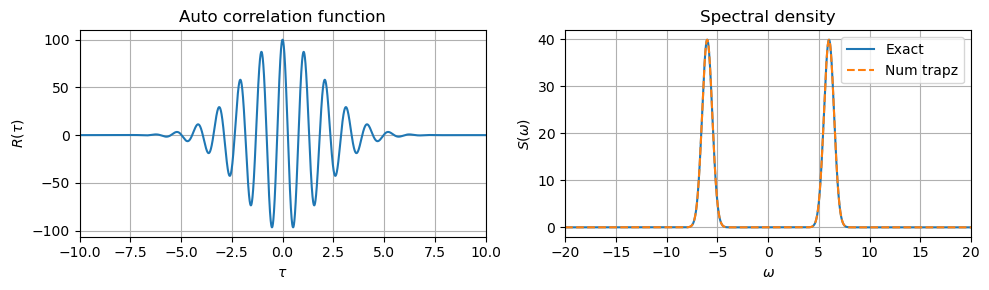

In [10]:
# Numerical integration by trapezoidal rule

# Solve integral for each omega
S_num = np.zeros(omega.shape[0],dtype=complex)
for k in range(omega.shape[0]):
    S_num[k] = 1/(2*np.pi)*np.trapz(R*np.exp(-1j*omega[k]*tau),tau)

plt.figure(figsize=(10, 3))

# Plot auto correlation
plt.subplot(1, 2, 1)
plt.plot(tau,R)
plt.xlim(-10,10)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R(\tau)$')
plt.title('Auto correlation function')
plt.grid(True)

# Plot spectral density
plt.subplot(1, 2, 2)
plt.plot(omega,S, label='Exact')
plt.plot(omega,np.real(S_num), linestyle='--',label='Num trapz')
plt.xlim(-20,20)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.title('Spectral density')
plt.legend()
plt.grid()

plt.tight_layout()


## Method 3: FFT

The spectral density is defined as:

$$
S(\omega)=
\dfrac{1}{2 \pi}
\int_{-\infty}^{\infty}
R(\tau) \exp({-i \omega \tau}) \: \text{d} \tau
$$

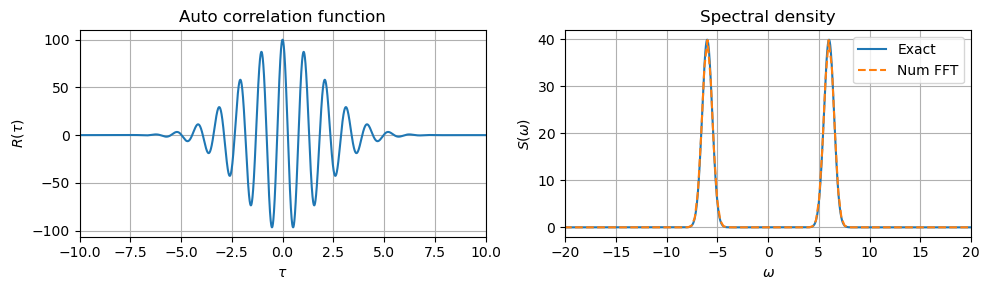

In [11]:

N=len(R) # Number of data points in time domain

S_fft = np.fft.fft(R)/N # DFT
f_fft = np.fft.fftfreq(N, d=(tau[1] - tau[0])) # Frequency axis in Hz

S_fft_shift = np.fft.fftshift(S_fft) # Shift elements in vector, goes from [-omega,...,0,...+omega]
f_fft_shift = np.fft.fftshift(f_fft)

S_fft_shift=S_fft_shift*np.exp(-1j*2*np.pi*f_fft_shift*tau[0]) # Compensate for time axis not starting at 0

S_fft_num=S_fft_shift*(tau[-1]-tau[0])/(2*np.pi) # Convert from a DFT to a continuous FT

omega_fft_shift=f_fft_shift*2*np.pi # Convert to rad/s


# Plot ACF
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(tau, R, label='ACF')
plt.xlim(-10,10)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R(\tau)$')
plt.title('Auto correlation function')
plt.grid(True)

# Plot ACF
plt.subplot(1, 2, 2)
plt.plot(omega,S, label='Exact')
plt.plot(omega_fft_shift,np.real(S_fft_num), linestyle='--',label='Num FFT')
plt.xlim(-20,20)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.title('Spectral density')
plt.legend()
plt.grid()

plt.tight_layout()
